In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="C:\\Windows\\Fonts\\malgun.ttf").get_name()
plt.rc("font", family = font_name)

import matplotlib as mlp
mlp.rcParams["axes.unicode_minus"] = False

In [2]:
# import urllib.request as req
# # from urllib.error import HTTPError, URLError
# import requests
# from bs4 import BeautifulSoup

In [3]:
# from selenium import webdriver
# from selenium.webdriver.common.by import By
# from selenium.webdriver.common.keys import Keys

# from webdriver_manager.chrome import ChromeDriverManager
# from selenium.webdriver.chrome.service import Service

# import time

In [4]:
# import folium
# import json

In [5]:
# from glob import glob

---

# 1. 구별 불법 주 · 정차 단속실적

## (1) 데이터 처리

### 1) 데이터 로드

- 불법 주 · 정차 단속실적(서울특별시청) : 2022 기준
- https://news.seoul.go.kr/traffic/archives/35239
- 크롤링

In [6]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

page = urlopen("https://news.seoul.go.kr/traffic/archives/35239")
soup = BeautifulSoup(page, "html.parser")

In [7]:
post=soup.find("div", id="post_content")

In [8]:
violation_table = post.find_all("table")[0]

In [9]:
violation_tr=violation_table.find_all("tr")[3:]

gu_name =[]
cnt = []

for tr in violation_tr:
    p = tr.find_all("p")
    if p[0].text=="중구" :
        gu_name.append(p[0].text)
    else :
        gu_name.append(p[0].text+"구")
    cnt.append(p[-1].text) 

In [57]:
df = pd.DataFrame({"시군구":gu_name, "단속건수":cnt})

In [58]:
df.sort_values(by="단속건수", ascending=False)

,시군구,단속건수
5,동대문구,"98,551"
20,관악구,"89,539"
14,양천구,"75,744"
2,용산구,"70,902"
11,은평구,"69,261"
16,구로구,"66,904"
3,성동구,"63,102"
4,광진구,"58,019"
10,노원구,"55,574"
19,동작구,"54,046"


In [59]:
df.info()     

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   시군구     25 non-null     object
 1   단속건수    25 non-null     object
dtypes: object(2)
memory usage: 528.0+ bytes


In [60]:
df["단속건수"]=df["단속건수"].str.replace(",","").astype(float)

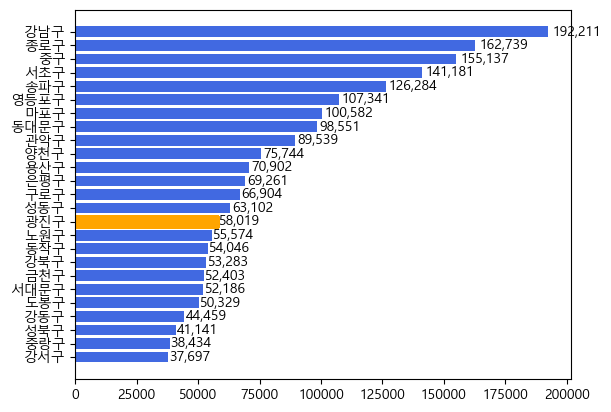

In [61]:
sort_df=df.sort_values(by="단속건수").reset_index()
for i in range(len(sort_df["시군구"])):
    bars=plt.barh(sort_df["시군구"],sort_df["단속건수"], color="royalblue")
    bars[sort_df[sort_df["시군구"]=='광진구'].index[0]].set_color('orange')
for i in bars.patches :
    x, y, width, height = i.get_bbox().bounds
#     print(x, y, width, height)
    plt.text(width*1.01, y+height/2, '{:,}'.format(int(width)), va='center')

In [68]:
df1=df.set_index("시군구")

import folium
import json

geo=json.load(open("../../Data/기타/skorea_municipalities_geo_simple_seoul.json",
                  encoding="utf-8"))

map = folium.Map(location=[37.5502, 126.982],zoom_start=10)

map.choropleth(geo_data=geo,  data=df1["단속건수"], 
               key_on="feature.id",
               columns=[df1.index , df1["단속건수"]],
               fill_color="PuRd")
map

C:\Users\acorn\anaconda3\lib\site-packages\folium\folium.py:465: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [15]:
# df["정규화"]=(df["단속건수"] - df["단속건수"].min())/(df["단속건수"].max() - df["단속건수"].min()) 

In [16]:
# df.sort_values(by="정규화",ascending=False)

### (2) 구별 비교

- 광진구의 교통량, 주차면수, 차량 대비 단속건수는 다른 구에 비해 낮은편이라 자료 활용이 어려움

In [17]:
park = pd.read_csv("../../Data/차,주차장/구별 차량대비 주차면수.csv")
traffic=pd.read_csv("../../Data/차,주차장/구별교통량평균.csv")

In [18]:
res=pd.merge(df,park,on="시군구", how="outer").merge(traffic, on="시군구", how="outer")
res.rename(columns={"시간대별평균":"교통량평균", "차량합계":"차량등록대수",
                   "합계면수":"주차면수"},inplace=True)
res.head()

,시군구,단속건수,차량등록대수,주차면수,주차장확보율,Unnamed: 0,교통량평균
0,종로구,162739.0,50756,92062,181.381512,21.0,741.480469
1,중구,155137.0,59744,109153,182.701192,22.0,580.353152
2,용산구,70902.0,75234,118632,157.684026,19.0,1655.397747
3,성동구,63102.0,106021,134544,126.903161,14.0,1442.241220
4,광진구,58019.0,99115,134389,135.588962,4.0,2423.412202


In [19]:
del res["Unnamed: 0"]

In [20]:
res["교통량대비단속건수"]=res["단속건수"]/res["교통량평균"]
res["주차면수대비단속건수"]=res["단속건수"]/res["주차면수"]
res["차량대비단속건수"]=res["단속건수"]/res["차량등록대수"]

In [21]:
res.to_csv("../../Data/차,주차장/구별+주자장+단속+교통량.csv", 
           encoding="utf-8")

In [22]:
res.sort_values(by="교통량대비단속건수", ascending=False)

,시군구,단속건수,차량등록대수,주차면수,주차장확보율,교통량평균,교통량대비단속건수,주차면수대비단속건수,차량대비단속건수
20,관악구,89539.0,118273,153960,130.173412,308.089286,290.626790,0.581573,0.757054
1,중구,155137.0,59744,109153,182.701192,580.353152,267.314823,1.421280,2.596696
0,종로구,162739.0,50756,92062,181.381512,741.480469,219.478472,1.767711,3.206301
22,강남구,192211.0,245487,413898,168.602818,1379.695387,139.314085,0.464392,0.782978
16,구로구,66904.0,146038,191823,131.351429,700.373214,95.526212,0.348780,0.458127
23,송파구,126284.0,249256,339227,136.095821,1494.971974,84.472487,0.372270,0.506644
18,영등포구,107341.0,145490,203359,139.775242,1345.250083,79.792599,0.527840,0.737790
11,은평구,69261.0,133791,176603,131.999163,890.304315,77.794748,0.392185,0.517681
21,서초구,141181.0,176494,310949,176.181060,1869.332664,75.524813,0.454033,0.799920
12,서대문구,52186.0,89542,132942,148.468875,821.323661,63.538898,0.392547,0.582810


In [23]:
res.sort_values(by="주차면수대비단속건수", ascending=False)

,시군구,단속건수,차량등록대수,주차면수,주차장확보율,교통량평균,교통량대비단속건수,주차면수대비단속건수,차량대비단속건수
0,종로구,162739.0,50756,92062,181.381512,741.480469,219.478472,1.767711,3.206301
1,중구,155137.0,59744,109153,182.701192,580.353152,267.314823,1.421280,2.596696
5,동대문구,98551.0,98603,148103,150.201312,2821.638393,34.926871,0.665422,0.999473
2,용산구,70902.0,75234,118632,157.684026,1655.397747,42.830794,0.597663,0.942420
20,관악구,89539.0,118273,153960,130.173412,308.089286,290.626790,0.581573,0.757054
8,강북구,53283.0,75122,96636,128.638748,NaN,NaN,0.551378,0.709286
18,영등포구,107341.0,145490,203359,139.775242,1345.250083,79.792599,0.527840,0.737790
13,마포구,100582.0,121250,199423,164.472577,2833.697619,35.494966,0.504365,0.829542
3,성동구,63102.0,106021,134544,126.903161,1442.241220,43.752736,0.469006,0.595184
22,강남구,192211.0,245487,413898,168.602818,1379.695387,139.314085,0.464392,0.782978


In [24]:
res.sort_values(by="차량대비단속건수", ascending=False)

,시군구,단속건수,차량등록대수,주차면수,주차장확보율,교통량평균,교통량대비단속건수,주차면수대비단속건수,차량대비단속건수
0,종로구,162739.0,50756,92062,181.381512,741.480469,219.478472,1.767711,3.206301
1,중구,155137.0,59744,109153,182.701192,580.353152,267.314823,1.421280,2.596696
5,동대문구,98551.0,98603,148103,150.201312,2821.638393,34.926871,0.665422,0.999473
2,용산구,70902.0,75234,118632,157.684026,1655.397747,42.830794,0.597663,0.942420
13,마포구,100582.0,121250,199423,164.472577,2833.697619,35.494966,0.504365,0.829542
21,서초구,141181.0,176494,310949,176.181060,1869.332664,75.524813,0.454033,0.799920
22,강남구,192211.0,245487,413898,168.602818,1379.695387,139.314085,0.464392,0.782978
20,관악구,89539.0,118273,153960,130.173412,308.089286,290.626790,0.581573,0.757054
18,영등포구,107341.0,145490,203359,139.775242,1345.250083,79.792599,0.527840,0.737790
8,강북구,53283.0,75122,96636,128.638748,NaN,NaN,0.551378,0.709286


# 2. 광진구 행정동별 비교

- 데이터 : 공공데이터포탈의 광진구 주정차단속현황 (2022년만 추출하여 활용)

## (1) 데이터 처리

In [25]:
gj_violation = pd.read_csv("../../Data/차,주차장/서울특별시 광진구_주정차단속현황_20230228.csv", 
                     encoding="euc-kr")
gj_violation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39732 entries, 0 to 39731
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   단속일시    39732 non-null  object
 1   단속원금    39732 non-null  int64 
 2   단속동     39732 non-null  object
 3   단속장소    39732 non-null  object
 4   위반내용    39732 non-null  object
 5   견인지시    39732 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.8+ MB


In [26]:
gj_violation.head()

,단속일시,단속원금,단속동,단속장소,위반내용,견인지시
0,2022-01-01 02:29:00,40000,중곡동,서울특별시 광진구 영화사로5길 19,교통소통장애,미견인
1,2022-01-01 06:41:00,80000,중곡동,150-196,소화전,미견인
2,2022-01-01 07:02:00,40000,구의동,서울 광진구 구의동 660-1 주차장앞,교통소통장애,미견인
3,2022-01-01 07:29:00,40000,구의동,서울 광진구 구의동 6-4,횡단보도,견인처리
4,2022-01-01 10:55:00,40000,구의동,리젠트오피스텔건너편,안전지대,미견인


### (1) 22년도 데이터 추출

In [27]:
gj_violation["연도"]=gj_violation["단속일시"].str.extract('([0-9]{4})')

In [28]:
gj_v_2022=gj_violation[gj_violation["연도"]=="2022"]

### (2) 행정동 추출

In [29]:
dong_name = gj_v_2022["단속동"].unique()
dong_name

array(['중곡동', '구의동', '광장동', '자양동', '군자동', '화양동', '능동', '동일로', '광나루로',
       '능동로', '자양강변길', '구의강변로3가길', '긴고랑로', '아차산로70길', '면목로17길', '강변북로',
       '아차산로58길', '천호대로104길', '동일로60길', '군자로'], dtype=object)

In [30]:
import requests

head = {"Authorization":"KakaoAK cbe1a3567ce9912ad46a4cf87043ad88"}

ka_dong = []

for a in dong_name:
    if a[-1] == "동" :
        ka_dong.append(a)
    else :
        url = "https://dapi.kakao.com/v2/local/search/address.json?query={}".format(a)
        place = requests.get(url,headers=head).json()['documents'][0]['road_address']['region_3depth_name']
        ka_dong.append(place)

In [31]:
match_addr=pd.DataFrame({"단속동":dong_name, "행정동":ka_dong})


In [32]:
df = pd.merge(gj_v_2022, match_addr, on="단속동")

### (4) 행정동별 단속실적

In [33]:
dong_res=df.pivot_table(values="위반내용", index = "행정동" , aggfunc="count")
dong_res

,위반내용
행정동,
광장동,4291
구의동,8939
군자동,2652
능동,2071
자양동,7141
중곡동,8273
화양동,2334


<AxesSubplot:ylabel='행정동'>

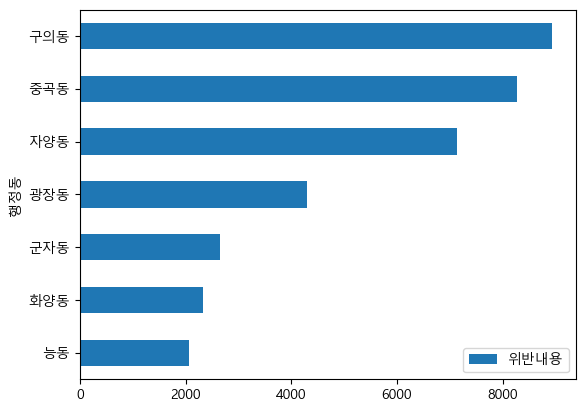

In [34]:
dong_res.sort_values(by="위반내용").plot.barh()

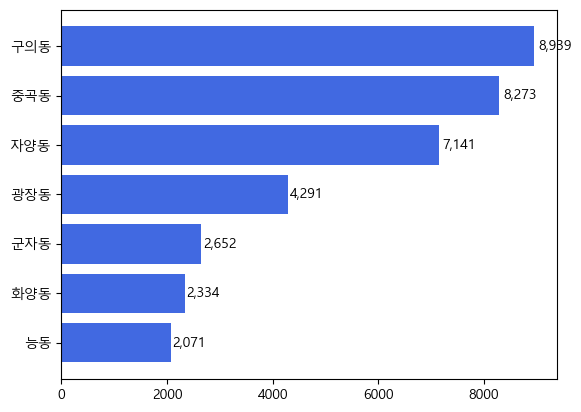

In [35]:
sort_dong_res=dong_res.sort_values(by="위반내용").reset_index()
for i in range(len(sort_dong_res["행정동"])):
    bars=plt.barh(sort_dong_res["행정동"],sort_dong_res["위반내용"],
                 color="royalblue")
for i in bars.patches :
    x, y, width, height = i.get_bbox().bounds
#     print(x, y, width, height)
    plt.text(width*1.01, y+height/2, '{:,}'.format(int(width)), va='center')

In [36]:
import folium
import json
geo=json.load(open("../../Data/건축물/seoul_bubjungdong.json",
                  encoding="euc-kr"))

map = folium.Map(location=[37.548144, 127.085753],zoom_start=13)

map.choropleth(geo_data=geo,  data=dong_res["위반내용"], 
               key_on="feature.id",
               columns=[dong_res.index, dong_res["위반내용"]],
               fill_color="PuRd")
map

C:\Users\acorn\anaconda3\lib\site-packages\folium\folium.py:465: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


### (5) 행정동별 위반 내용

In [37]:
df.pivot_table(values = "단속일시", index="행정동",columns="위반내용",aggfunc="count")

위반내용,건널목,교차로,교통소통장애,도로 모퉁이,도로공사구역,버스정류소,보도,소방기계 비치장소,소방차(긴급차량)통행장애,소화전,안전지대,유턴지역,이면도로주차,이중주차,주정차금지(황색실선)구역,주차구획선외 주차,주차금지(황색점선)구역,주차방법위반,특별구역,횡단보도
행정동,,,,,,,,,,,,,,,,,,,,
광장동,8.0,177.0,1523.0,98.0,1.0,482.0,532.0,1.0,NaN,95.0,259.0,NaN,NaN,1.0,82.0,9.0,643.0,28.0,99.0,253.0
구의동,1.0,93.0,2549.0,261.0,NaN,164.0,663.0,21.0,1.0,110.0,832.0,1.0,NaN,12.0,2172.0,7.0,1455.0,39.0,18.0,540.0
군자동,NaN,21.0,425.0,68.0,NaN,6.0,871.0,1.0,1.0,12.0,88.0,NaN,1.0,4.0,286.0,NaN,793.0,6.0,16.0,53.0
능동,NaN,44.0,707.0,106.0,NaN,19.0,550.0,4.0,NaN,4.0,NaN,NaN,NaN,1.0,352.0,31.0,223.0,4.0,2.0,24.0
자양동,7.0,277.0,2216.0,448.0,NaN,57.0,1183.0,8.0,12.0,153.0,148.0,NaN,NaN,1.0,463.0,36.0,1340.0,25.0,31.0,736.0
중곡동,8.0,163.0,1270.0,446.0,NaN,1443.0,1797.0,13.0,9.0,106.0,4.0,1.0,NaN,NaN,202.0,14.0,2244.0,14.0,26.0,513.0
화양동,NaN,90.0,973.0,212.0,NaN,19.0,203.0,1.0,1.0,10.0,121.0,NaN,NaN,2.0,289.0,NaN,263.0,14.0,5.0,131.0


### (6) 병합

- 결과 : 
    - 2022년 구의동의 주정차위반실적이 가장 높게 나타남
    - 등록차량대비 위반 실적은 능동, 화양동, 군자동 순으로 높게 나타남
    - 면수대비 위반실적은 군자동, 중곡동, 능동 순으로 높게 나타남

In [38]:
park=pd.read_csv("../../Data/차,주차장/광진구동별주차장확보율.csv")

In [39]:
m=pd.merge(dong_res, park, on="행정동")
m.columns=["행정동","위반실적","차량등록대수","주차면수","주차장확보율"]
m.set_index("행정동", inplace=True)

In [40]:
m["차량대비위반실적"]=m["위반실적"]/m["차량등록대수"]
m["면수대비위반실적"]=m["위반실적"]/m["주차면수"]

In [41]:
m.sort_values(by ="차량대비위반실적",  ascending=False)

,위반실적,차량등록대수,주차면수,주차장확보율,차량대비위반실적,면수대비위반실적
행정동,,,,,,
능동,2071,3050,6560,46.493902,0.679016,0.315701
화양동,2334,4140,10647,38.884193,0.563768,0.219217
군자동,2652,5160,7263,71.045023,0.513953,0.365138
구의동,8939,23133,32131,71.995892,0.386418,0.278205
중곡동,8273,21432,25041,85.587636,0.386012,0.330378
광장동,4291,11677,16425,71.092846,0.367475,0.261248
자양동,7141,30457,36322,83.852761,0.234462,0.196603


<AxesSubplot:ylabel='행정동'>

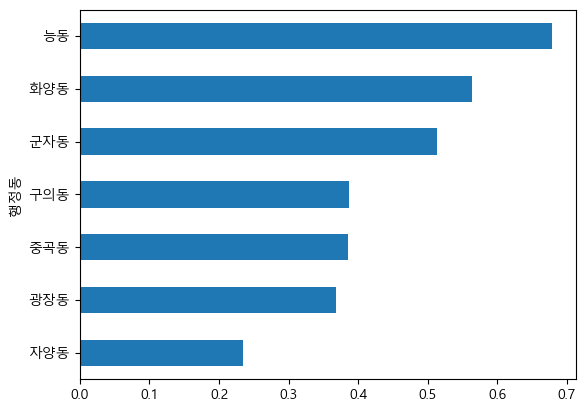

In [42]:
m["차량대비위반실적"].sort_values().plot.barh()

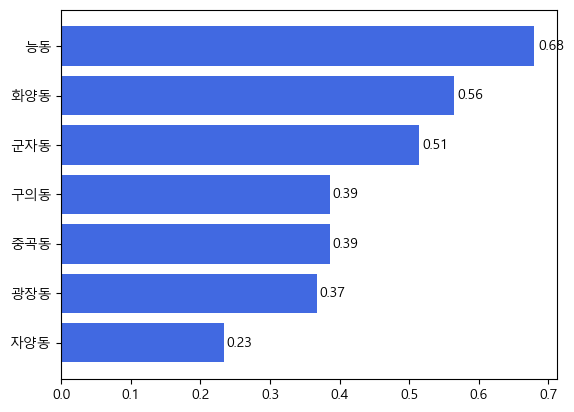

In [43]:
sort_res=m.sort_values(by="차량대비위반실적").reset_index()
for i in range(len(sort_res["행정동"])):
    bars=plt.barh(sort_res["행정동"],sort_res["차량대비위반실적"],
                 color="royalblue")
for i in bars.patches :
    x, y, width, height = i.get_bbox().bounds
#     print(x, y, width, height)
    plt.text(width*1.01, y+height/2, '%.2f'%(width), va='center')

In [44]:
import folium
import json
geo=json.load(open("../../Data/건축물/seoul_bubjungdong.json",
                  encoding="euc-kr"))

map = folium.Map(location=[37.548144, 127.085753],zoom_start=13)

map.choropleth(geo_data=geo,  data=m["차량대비위반실적"], 
               key_on="feature.id",
               columns=[m.index, m["차량대비위반실적"]],
               fill_color="PuRd")
map

C:\Users\acorn\anaconda3\lib\site-packages\folium\folium.py:465: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


---

In [45]:
m.sort_values(by ="면수대비위반실적",  ascending=False)

,위반실적,차량등록대수,주차면수,주차장확보율,차량대비위반실적,면수대비위반실적
행정동,,,,,,
군자동,2652,5160,7263,71.045023,0.513953,0.365138
중곡동,8273,21432,25041,85.587636,0.386012,0.330378
능동,2071,3050,6560,46.493902,0.679016,0.315701
구의동,8939,23133,32131,71.995892,0.386418,0.278205
광장동,4291,11677,16425,71.092846,0.367475,0.261248
화양동,2334,4140,10647,38.884193,0.563768,0.219217
자양동,7141,30457,36322,83.852761,0.234462,0.196603


<AxesSubplot:ylabel='행정동'>

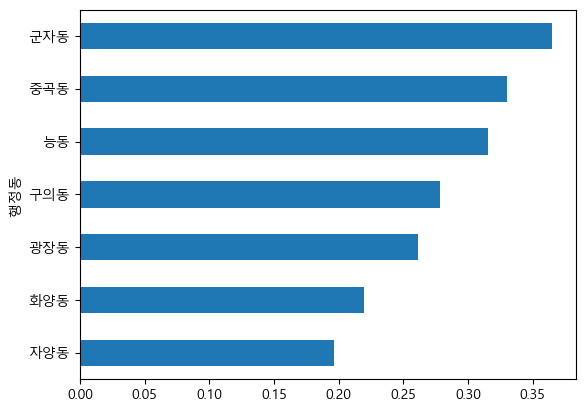

In [46]:
m["면수대비위반실적"].sort_values().plot.barh()